In [1]:
%load_ext autoreload

%autoreload 2

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import glob
import os
import sys

from tqdm.notebook import tqdm
from datetime import datetime

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import FunctionTransformer, RobustScaler, MinMaxScaler, StandardScaler, LabelBinarizer
from sklearn.preprocessing import normalize, robust_scale, minmax_scale

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier

from sklearn.kernel_approximation import RBFSampler, Nystroem

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, GroupKFold

from sklearn.metrics import make_scorer, confusion_matrix, roc_auc_score, roc_curve, plot_confusion_matrix, f1_score, recall_score

from sklearn.multiclass import OneVsRestClassifier

from mlxtend.evaluate import scoring

# Preparing Metadata/Labels

In [4]:
all_files = pd.DataFrame(glob.glob("/mnt/b/Git_Projects/Biospec_Analysis/Extracted_Spectra/*.pickle"), columns = ["hdf_loc"])
all_files["TMA"] = all_files.apply(lambda row: float(row["hdf_loc"].split("/")[-1][4:5]), axis = 1)
all_files["Core"] = all_files.apply(lambda row: row["hdf_loc"].split("/")[-1][8:-7], axis = 1)

In [5]:
metadata = pd.read_excel("/mnt/b/Google_Drive/PhD/Project with Janet/Scoring grids Advancing Front (TMAs 1-3).xlsx"
              , sheet_name = "reformatted")

metadata = metadata.merge(all_files, left_on = ["TMA", "TMA site"], right_on = ["TMA", "Core"])
print(metadata.shape)

(79, 18)


In [6]:
new_metadata = pd.read_excel("/mnt/b/Google_Drive/PhD/Project with Janet/new_metadata.xlsx")

In [7]:
new_metadata["DODvsAlive"] = new_metadata["OUTCOME"].map(
                            {"DOD" : "DOD",
                             "alive": "Other",
                             "died other" : "Other",
                             "died" : "Other",
                             "Died" : "Other",
                             "Died other": "Other"})

new_metadata["DiedvsAlive"] = new_metadata["OUTCOME"].map(
                            {"DOD" : "Died",
                             "alive": "Alive",
                             "died other" : "Died",
                             "died" : "Died",
                             "Died" : "Died",
                             "Died other": "Died"})

In [8]:
new_metadata['lifespan'] = new_metadata['Date of death'] - new_metadata['date of diag']

new_metadata["2year"] = new_metadata['lifespan'].dt.days < 730
new_metadata["5year"] = new_metadata['lifespan'].dt.days < 1825

In [9]:
new_metadata.head()

,Patient_Number,gender,date of diag,age @ diag,site,pT,pN,stage,ECS,OUTCOME,...,Date of recurrence,site of recurrence,Last seen/reviewed,Last updated,OUTCOME.updated by,DODvsAlive,DiedvsAlive,lifespan,2year,5year
0,3143,m,2004-03-29,58,floor of mouth,4,0,4,N,DOD,...,2005-11-25,local,NaT,2020-05-11,FGD,DOD,Died,3341 days,False,False
1,3167,m,2004-09-30,74,floor of mouth,2,2,4,y,DOD,...,2005-09-07,regional only,NaT,2012-10-04,CBarry,DOD,Died,390 days,True,True
2,3169,m,2004-10-28,63,floor of mouth,3,1,3,N,died other,...,NaT,NaN,NaT,2006-12-01,RJS,Other,Died,652 days,True,True
3,3170,m,2004-11-22,59,other,4,2b,4a,Y,Died other,...,NaT,NaN,NaT,2020-04-01,FGD,Other,Died,3690 days,False,False
4,3230,m,2006-01-26,74,tongue,2,1,3,Y,DOD,...,2006-06-02,local and regional,NaT,2011-05-01,AS,DOD,Died,161 days,True,True


In [10]:
new_metadata["2year"] = new_metadata.apply(lambda row: True if (row['Date of death']-row['date of diag']).days<730 and row.OUTCOME!='Alive' else False, axis = 1)
new_metadata["5year"] = new_metadata.apply(lambda row: True if 730<(row['Date of death']-row['date of diag']).days<1825 and row.OUTCOME!='Alive' else False, axis = 1)

new_metadata["Alive"] = new_metadata.apply(lambda row: True if 730<(row['Last seen/reviewed']-row['date of diag']).days<1825 and row.OUTCOME=='Alive' else False, axis = 1)

# Import data and preprocess

In [11]:
from Preprocessing_Methods import *

import sys

sys.path.append("/mnt/b/Git_Projects/Biospec_Analysis/UNET")

In [12]:
select = ['Tumour']

total = pd.concat({"{}-{}".format(row["TMA"], row["Core"]):
                   truncate(pd.read_pickle(row["hdf_loc"]).query(f"Tissue in {select}").sample(frac = 1), start = 1000, end = 1800)
                   for name, row in tqdm(list(metadata.iterrows()))}, names = ["ID"])

wn_cols = total.columns
#total = total.merge(new_metadata, left_on = "Patient nu ", right_on = "Patient Number")
#total = total.drop(np.nan, level = "Overall Death ")

In [13]:
total = total.reset_index().merge(new_metadata.loc[:, ["Patient_Number", "OUTCOME", "DODvsAlive", "DiedvsAlive", 'lifespan', "2year", "5year"]], left_on = "Patient nu ", right_on = "Patient_Number", how = 'inner')
total = total.set_index(list(total.columns.difference(wn_cols))).dropna(axis = 1)

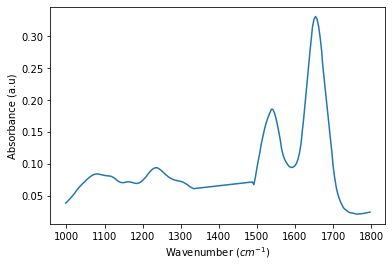

In [14]:
fig, axes = plt.subplots(nrows = 1, figsize = (6,4), sharex = True)

total.mean(axis = 0).T.plot(ax = axes)
axes.set_xlabel("Wavenumber $(cm^{-1})$")
axes.set_ylabel("Absorbance (a.u)")
fig.savefig(os.getcwd()+ "/Plots/Mean_Spectra.png", bbox_inches = 'tight')

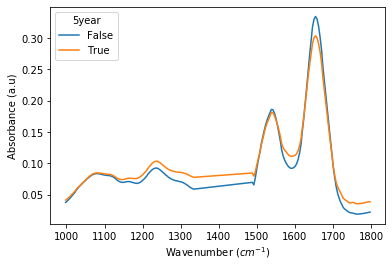

In [15]:
fig, axes = plt.subplots(nrows = 1, figsize = (6,4), sharex = True)

total.groupby("5year").mean().T.plot(ax = axes)
axes.set_xlabel("Wavenumber $(cm^{-1})$")
axes.set_ylabel("Absorbance (a.u)")
fig.savefig(os.getcwd()+ "/Plots/Mean_ECS_Spectra.png", bbox_inches = 'tight')

In [16]:
pcapipe = Pipeline([
    ("Normalise spectra", FunctionTransformer(robust_scale, kw_args = {"axis": 1})),
    ("Scaler", RobustScaler()),
    ("PCA", PCA())
])

In [17]:
n = total.reset_index()["Patient_Number"].value_counts().min()
total_ = total.groupby("Patient_Number", group_keys=False).apply(lambda g: g.sample(n))

In [18]:
total_.index.names

FrozenList(['2year', '5year', 'Annotation_loc', 'Core_x', 'Core_y', 'Corrected Site AJCC/UICC', 'DODvsAlive', 'Diagnosis Age', 'DiedvsAlive', 'ECS', 'ID', 'N stage', 'OUTCOME', 'Overall Death ', 'Pathogical Stage', 'Patient nu ', 'Patient_Number', 'T stage', 'TMA', 'TMA site', 'Tissue', 'advancing front type', 'diff', 'envi_loc', 'gender', 'lifespan', 'radiotherapy', 'recurrence', 'survival (months)'])

In [19]:
total_.head()

998.0   \
2year 5year Annotation_loc                                     Core_x Core_y Corrected Site AJCC/UICC DODvsAlive Diagnosis Age DiedvsAlive ECS ID     N stage OUTCOME    Overall Death  Pathogical Stage Patient nu  Patient_Number T stage TMA TMA site Tissue advancing front type diff     envi_loc                                           gender lifespan radiotherapy recurrence survival (months)             
True  False /mnt/b/Google_Drive/PhD/Project with Janet/Labe... D9     D9     other                    Other      59.0          Died        yes 1.0-D9 2a      Died other yes            pT4aN2aMx        3237        3237           4a      1.0 D9       Tumour non-cohesive         mod well /mnt/b/Google_Drive/PhD/Project with Janet/Kohl... m      574 days yes          yes        2.0                0.044554   
                                                                                                                                                                                                                                                                                                                                                                                         2.0                0.055026   
                                                                                                                                                                                                                                                                                                                                                                                         2.0                0.039708   
            /mnt/b/Google_Drive/PhD/Project with Janet/Labe... B5     B5     other                    Other      59.0          Died        yes 2.0-B5 2a      Died other yes            pT4aN2aMx        3237        3237           4a      2.0 B5       Tumour non-cohesive         mod well /mnt/b/Google_Drive/PhD/Project with Janet/Kohl... m      574 days yes          yes        2.0                0.038962   
                                                                                                                                                                                                                                                                                                                                                                                         2.0                0.031609   

                                                                                                                                                                                                                                                                                                                                                                                                              1002.0  \
2year 5year Annotation_loc                                     Core_x Core_y Corrected Site AJCC/UICC DODvsAlive Diagnosis Age DiedvsAlive ECS ID     N stage OUTCOME    Overall Death  Pathogical Stage Patient nu  Patient_Number T stage TMA TMA site Tissue advancing front type diff     envi_loc                                           gender lifespan radiotherapy recurrence survival (months)             
True  False /mnt/b/Google_Drive/PhD/Project with Janet/Labe... D9     D9     other                    Other      59.0          Died        yes 1.0-D9 2a      Died other yes            pT4aN2aMx        3237        3237           4a      1.0 D9       Tumour non-cohesive         mod well /mnt/b/Google_Drive/PhD/Project with Janet/Kohl... m      574 days yes          yes        2.0                0.045734   
                                                                                                                                                                                                                                                                                                                             

In [20]:
import statsmodels.api as sm

In [21]:
pd.crosstab(total.reset_index()["DODvsAlive"], total.reset_index()["TMA"])

TMA,1.0,2.0
DODvsAlive,,
DOD,45503,57254
Other,108065,88785


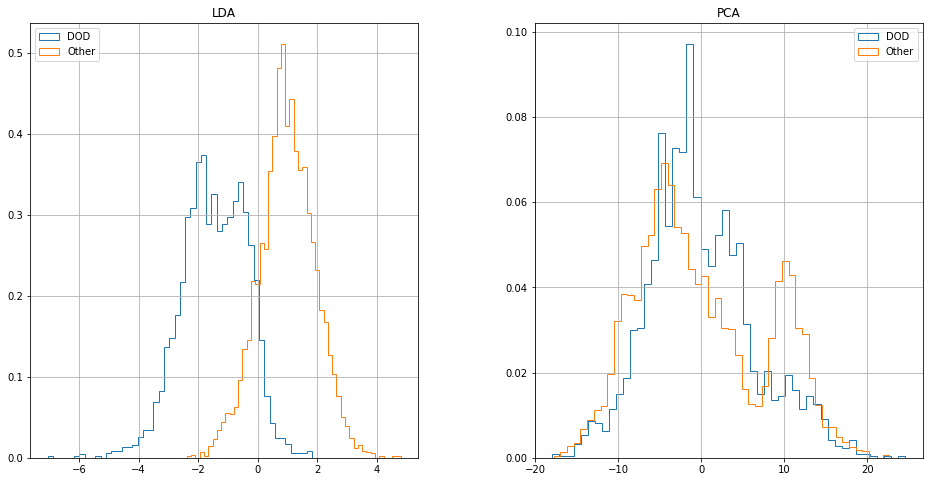

In [22]:
y = "DODvsAlive"

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (16,8))

data = total_.copy().sample(frac = 1)#.drop(np.nan, level = "DODvsAlive")

total_lda = pd.DataFrame(
    LinearDiscriminantAnalysis(n_components = 1).fit_transform(pcapipe.fit_transform(data), data.reset_index()[f"{y}"].values)
    , index = data.index)


for name, df in total_lda.groupby(level = f"{y}"):

    df.hist(0, bins = 50, ax = ax1, histtype = 'step', label = name, density = True)

ax1.set_title("LDA")
ax1.legend()
    
total_pca = pd.DataFrame(
    PCA(n_components = 1).fit_transform(pcapipe.fit_transform(data), data.reset_index()[f"{y}"])
    , index = data.index)


for name, df in total_pca.groupby(level = f"{y}"):

    df.hist(0, bins = 50, ax = ax2, histtype = 'step', label = name, density = True)

ax2.set_title("PCA")
plt.legend()

## Hyperparameter Tuning

In [23]:
import kerastuner as kt

In [24]:
def build_RF(hp):

    clf = RandomForestClassifier()
    clf = clf.set_params(**{  'n_estimators': hp.Int('n_estimators', 10, 500, 10)
                        , 'class_weight': hp.Choice('class_weight', ['balanced', 'balanced_subsample'])
                        , 'max_depth' : hp.Int('max_depth', 1, 30, 1)
                       })
    
    scalers = {"Normalize" : normalize,
               "Robust"    : robust_scale,
               "MinMax"    : minmax_scale}
    
    scale1 = hp.Choice('scale1', ["Normalize", "Robust", "MinMax"])
    scale2 = hp.Choice('scale2', ["Normalize", "Robust", "MinMax"])

    pipe = Pipeline([
    ("Normalise spectra", FunctionTransformer(scalers[scale1] , kw_args = {"axis": 1})),
    ("Scaler", FunctionTransformer(scalers[scale2] , kw_args = {"axis": 0})),
    ("PCA", PCA(n_components = hp.Int("PCA_components", 1, 169, 1))),
    ("clf", clf)])
    
    return pipe

In [25]:
from xgboost import XGBClassifier

def build_XG(hp):

    params = {
        
        'eta': hp.Float('eta', 0, 1, 0.05),
        'gamma': hp.Float('gamma', 0, 1, 0.05),
        'max_depth' : hp.Int('max_depth', 1, 15, 1),
        'min_child_weight' : hp.Int('min_child_weight', 1, 20, 1),
        'subsample' : hp.Float('subsample', 0, 1, 0.05),
        'colsample_bytree' : hp.Float('colsample_bytree', 0, 1, 0.05),
        'lambda ' : hp.Float('lambda', 0, 1, 0.05),
        'alpha' : hp.Float('alpha', 0, 1, 0.05),
    }

    clf = XGBClassifier()
    clf = clf.set_params(**params)
    
    #---------------------------------------------------------------------------------------------------
    scalers = {"Normalize" : normalize,
               "Robust"    : robust_scale,
               "MinMax"    : minmax_scale}
    
    # Decide pre processing steps
    scale1 = hp.Choice('scale1', ["Normalize", "Robust", "MinMax"])
    scale2 = hp.Choice('scale2', ["Normalize", "Robust", "MinMax"])

    pipe = Pipeline([
    ("Normalise spectra", FunctionTransformer(scalers[scale1] , kw_args = {"axis": 1})),
    ("Scaler", FunctionTransformer(scalers[scale2] , kw_args = {"axis": 0})),
    #("RBFSampler", RBFSampler(gamma = hp.Float("RBF_gamma", 0, 5), n_components = hp.Int("RB_components", 1, 169, 1))),
    ("PCA", PCA(n_components = hp.Int("PCA_components", 1, len(data.columns) - 1, 1))),
    ("clf", clf)])
    
    return pipe

In [26]:
def build_LDA(hp):
    
    params = {
        'n_components' : hp.Int("PCA_components", 1, len(data.columns) - 1, 1),
    }

    clf = LinearDiscriminantAnalysis()
    clf = clf.set_params(**params)
    
    #---------------------------------------------------------------------------------------------------
    scalers = {"Normalize" : normalize,
               "Robust"    : robust_scale,
               "MinMax"    : minmax_scale}
    
    scale1 = hp.Choice('scale1', ["Normalize", "Robust", "MinMax"])
    scale2 = hp.Choice('scale2', ["Normalize", "Robust", "MinMax"])

    pipe = Pipeline([
    ("Normalise spectra", FunctionTransformer(scalers[scale1] , kw_args = {"axis": 1})),
    ("Scaler", FunctionTransformer(scalers[scale2] , kw_args = {"axis": 0})),
    #("RBFSampler", RBFSampler(gamma = hp.Float("RBF_gamma", 0, 5), n_components = hp.Int("RB_components", 1, 169, 1))),
    ("PCA", PCA(n_components = hp.Int("PCA_components", 1, len(data.columns) - 1, 1))),
    ("clf", clf)])
    
    return pipe

In [27]:
from sklearn.svm import SVC

def build_SVM(hp):
    
    params = {
        
        'C': hp.Float('eta', 0, 1, 0.05),
        'gamma': hp.Float('gamma', 0, 1, 0.05),
        'class_weight': 'balanced'
    }

    clf = SVC(probability = True)
    clf = clf.set_params(**params)
    
    #---------------------------------------------------------------------------------------------------
    scalers = {"Normalize" : normalize,
               "Robust"    : robust_scale,
               "MinMax"    : minmax_scale}
    
    scale1 = hp.Choice('scale1', ["Normalize", "Robust", "MinMax"])
    scale2 = hp.Choice('scale2', ["Normalize", "Robust", "MinMax"])

    pipe = Pipeline([
    ("Normalise spectra", FunctionTransformer(scalers[scale1] , kw_args = {"axis": 1})),
    ("Scaler", FunctionTransformer(scalers[scale2] , kw_args = {"axis": 0})),
    ("RBFSampler", RBFSampler(gamma = hp.Float("RBF_gamma", 0, 5), n_components = hp.Int("RB_components", 1, len(data.columns)-1, 1))),
    #("PCA", PCA(n_components = hp.Int("PCA_components", 1, 169, 1))),
    ("clf", clf)])
    
    return pipe

In [28]:
def get_weights(column):
    
    counts = column.value_counts()
    weight_dict = dict(zip(counts.index, [(counts.values.sum()/n) for n in counts.values]))
    
    return column.map(weight_dict).values

In [29]:
group = "Patient_Number"
y = "DODvsAlive"

#data = (total - paraffin.mean(axis = 0)).sample(frac = 0.1)
data = total.copy().sample(frac = 1)#.query("DODvsAlive != 'Other'")#.drop(np.nan, level = y)

 
data["sample_weights"] = get_weights(data.reset_index()[f"{group}"]) * get_weights(data.reset_index()[f"{y}"])

# Splt the data set into training and validation sets based on patient number
train_pat, valid_pat = train_test_split(data.reset_index()[f"{group}"].unique(), test_size = 0.2, shuffle = True)

print(f"N train patients: \t{len(train_pat)}\n{train_pat}")
print(f"N test patients: \t{len(valid_pat)}\n{valid_pat}")


train_data = data.query(f"{group} in {list(train_pat)}")
validation_data = data.query(f"{group} in {list(valid_pat)}")


X_train, X_valid = train_data.drop(["sample_weights"], axis = 1), validation_data.drop(["sample_weights"], axis = 1), 
y_train, y_valid = train_data.reset_index()[f"{y}"], validation_data.reset_index()[f"{y}"]
w_train, w_test = train_data.reset_index()["sample_weights"], validation_data.reset_index()["sample_weights"]


y_train.index = X_train.index
y_valid.index = X_valid.index

groups = X_train.reset_index()[f"{group}"]
groups.index = X_train.index


lb = LabelBinarizer().fit(data.reset_index()[f"{y}"])

y_train_b = pd.DataFrame(lb.transform(y_train))
y_valid_b = pd.DataFrame(lb.transform(y_valid))

scorer = make_scorer(roc_auc_score, needs_proba = True, average = 'weighted')

date_time = datetime.now().strftime("%m.%d.%Y_%H:%M")

file_place = os.path.join(os.getcwd(), "Plots", y, date_time)
print(file_place)

if not os.path.exists(file_place):
    os.mkdir(file_place)
    
print(lb.classes_)

N train patients: 	24
[3544 3485 3285 3354 3540 3271 3585 3484 3486 3507 3270 3237 3261 3568
 3254 3480 3535 3530 3483 3252 3251 3481 3542 3464]
N test patients: 	6
[3277 3302 3338 3550 3288 3531]
/mnt/b/Git_Projects/Biospec_Analysis/Plots/DODvsAlive/06.16.2020_20:17
['DOD' 'Other']


In [30]:
oracle = kt.oracles.BayesianOptimization(objective = kt.Objective('score', 'max')
                                         , max_trials = 10)              

tuner = kt.tuners.Sklearn(oracle = oracle
                          , cv = GroupKFold(n_splits = 2)
                          , hypermodel = build_XG
                          , directory = os.path.join(os.getcwd(), "KerasTuner", datetime.now().strftime("%d.%m.%Y_%H:%M:%S"))
                          , scoring = scorer
                         )

In [35]:
tuner.search(X_train.values, y_train
            #, {"clf__sample_weight": w_train}
            #, sample_weight = w_train
            , groups = groups
            )

TypeError: unhashable type: 'numpy.ndarray'

In [ ]:
best_XG = build_XG(tuner.get_best_hyperparameters()[0])

In [ ]:
best_XG.fit(X_train, y_train_b, clf__sample_weight = w_train)

In [ ]:
from sklearn.model_selection import cross_val_score
from mlxtend.evaluate import BootstrapOutOfBag

In [ ]:
def test_scorer(y, y_pred, **kwargs):
    
    print(y.shape)

    print(y_pred.shape)

In [ ]:
ldapipe = Pipeline([
    ("Normalise spectra", FunctionTransformer(robust_scale, kw_args = {"axis": 1})),
    ("Scaler", RobustScaler()),
    ("PCA", PCA()),
    ("clf", LinearDiscriminantAnalysis())
])

#totalpca = pcapipe.fit(total.append(paraffin))
#totalpca = pcapipe.fit(total.append(paraffin))

In [ ]:
from sklearn import metrics

In [ ]:
from sklearn.model_selection import LeaveOneOut

cv = LeaveOneOut()

In [ ]:
pd.crosstab(total.reset_index()["Patient_Number"], total.reset_index()["DODvsAlive"])

In [ ]:
data = total.copy().sample(frac = 0.3)
group = "Patient_Number"
y = "DODvsAlive"

scoring_dict = {
               # "Spec": make_scorer(scoring, metric = 'specificity')
               #,"Sens": make_scorer(scoring, metric = 'sensitivity')
               #,"ROC_Curve": make_scorer(roc_curve, needs_proba=True)
               #,"AUC": make_scorer(roc_auc_score, needs_proba=True)
                "Accuracy": make_scorer(metrics.accuracy_score)
               }


patients = data.reset_index()["Patient_Number"].unique()
data["sample_weights"] = get_weights(data.reset_index()[f"{group}"]) * get_weights(data.reset_index()[f"{y}"])

results = dict()

for train_i, test_i in tqdm(list(LeaveOneOut().split(patients))):
    
    train_pat , valid_pat = patients[train_i], patients[test_i]
    
    train_data = data.query(f"{group} in {list(train_pat)}")
    validation_data = data.query(f"{group} in {list(valid_pat)}")

    
    X_train, X_valid = train_data.drop(["sample_weights"], axis = 1), validation_data.drop(["sample_weights"], axis = 1), 
    y_train, y_valid = train_data.reset_index()[f"{y}"], validation_data.reset_index()[f"{y}"]
    w_train, w_test = train_data.reset_index()["sample_weights"], validation_data.reset_index()["sample_weights"]


    y_train.index = X_train.index
    y_valid.index = X_valid.index


    lb = LabelBinarizer().fit(data.reset_index()[f"{y}"])

    y_train_b = pd.DataFrame(lb.transform(y_train))
    y_valid_b = pd.DataFrame(lb.transform(y_valid))

    scorer = make_scorer(roc_auc_score, needs_proba = True, average = 'weighted')
    
    ldapipe.fit(X_train, y_train_b)
    
    scores = dict()

    for name, scorer in scoring_dict.items():
        
        scores[name] = scorer(ldapipe, X_valid, y_valid_b)
        
    results[valid_pat[0]] = scores

In [ ]:
pd.DataFrame(results).T.plot.bar()

In [ ]:
data = total.copy().sample(frac = 0.3)
group = "Patient_Number"
y = "DODvsAlive"

scoring_dict = {
               # "Spec": make_scorer(scoring, metric = 'specificity')
               #,"Sens": make_scorer(scoring, metric = 'sensitivity')
               #,"ROC_Curve": make_scorer(roc_curve, needs_proba=True)
               #,"AUC": make_scorer(roc_auc_score, needs_proba=True)
                "Accuracy": make_scorer(metrics.accuracy_score)
               }


patients = data.reset_index()["Patient_Number"].unique()
data["sample_weights"] = get_weights(data.reset_index()[f"{group}"]) * get_weights(data.reset_index()[f"{y}"])

results = dict()

for train_i, test_i in tqdm(list(LeaveOneOut().split(patients))):
    
    train_pat , valid_pat = patients[train_i], patients[test_i]
    
    train_data = data.query(f"{group} in {list(train_pat)}")
    validation_data = data.query(f"{group} in {list(valid_pat)}")

    
    X_train, X_valid = train_data.drop(["sample_weights"], axis = 1), validation_data.drop(["sample_weights"], axis = 1), 
    y_train, y_valid = train_data.reset_index()[f"{y}"], validation_data.reset_index()[f"{y}"]
    w_train, w_test = train_data.reset_index()["sample_weights"], validation_data.reset_index()["sample_weights"]
    

    y_train.index = X_train.index
    y_valid.index = X_valid.index
    
    groups = X_train.reset_index()[f"{group}"]
    groups.index = X_train.index


    lb = LabelBinarizer().fit(data.reset_index()[f"{y}"])

    y_train_b = pd.DataFrame(lb.transform(y_train))
    y_valid_b = pd.DataFrame(lb.transform(y_valid))

    scorer = make_scorer(roc_auc_score, needs_proba = True, average = 'weighted')
    
    ldapipe.fit(X_train, y_train_b)
    
    scores = dict()

    for name, scorer in scoring_dict.items():
        
        scores[name] = scorer(ldapipe, X_valid, y_valid_b)
        
    results[valid_pat[0]] = scores

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [ ]:
data = total.copy().sample(frac = 0.3)

scoring_dict = {
                "Spec": make_scorer(scoring, metric = 'specificity')
               ,"Sens": make_scorer(scoring, metric = 'sensitivity')
               ,"ROC_Curve": make_scorer(roc_curve)
               #,"AUC": make_scorer(roc_auc_score)
               }

#scoring_dict = {"TEst": make_scorer(test_scorer)}

y_b = LabelBinarizer().fit_transform(data.reset_index()["DODvsAlive"].values)


results = cross_validate(ldapipe
                , data.values
                , y_b 
                #, cv = BootstrapOutOfBag(n_splits=3)
                , cv = GroupKFold(n_splits = 2)
                , groups = data.reset_index()["Patient_Number"].values
                , scoring = scoring_dict
                , return_estimator = True
                , verbose = True
                , n_jobs = 1
               )

In [ ]:
results

In [ ]:
best_XG = results["estimator"][0]

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (10,6), sharex = True)

importances = np.matmul(best_XG.named_steps["clf"].coef_, best_XG.named_steps["PCA"].components_)

ax1.set_title("Feature Importances")
ax1.plot(data.columns, importances.T)
ax1.set_ylabel("Feature Importance")

ax2.set_title("Mean Tissue Spectrum")
#total.iloc[:,::3].groupby(f"{y}").plot.box(ax = ax2, showfliers = False)
#mean = total.groupby(f"{y}").mean().T.plot(ax = ax2)
#std = total.groupby(f"{y}").std().T.plot(ax = ax2)
#check.groupby("dod").mean().T.plot(ax = ax2)

for name, df in total.groupby(f"{y}"):
    
    mean, std = df.groupby(f"{y}").mean(), df.groupby(f"{y}").std()
    
    ax2.plot(total.columns, mean.T, label = name)

ax2.legend()
ax2.set_xlabel("Wavenumber $(cm^{-1})$")
ax2.set_ylabel("Absorbance (a.u)")

fig.savefig(os.path.join(file_place, "Importances.png"), bbox_inches = 'tight')

In [ ]:
y_true = y_valid_b
y_pred = best_XG.predict_proba(X_valid)[:,0]

fpr, tpr, t = roc_curve(y_true, y_pred)
AUC = roc_auc_score(y_true, y_pred)

scores = np.array([np.sqrt(((1-t)**2)+((0-(f))**2)) for f, t in zip(fpr,tpr)])
threshi = np.argmin(scores)

opt = t[threshi]
prec, rec, _ = precision_recall_curve(y_true, y_pred)

In [ ]:
fig, ax = plt.subplots()

ax.plot(t , scores, label = "Score")
#ax.plot(t , tpr, label = "True positive rate")
#ax.plot(t , fpr, label = "False positive rate")
ax.set_title('Optimal decision threshold')
ax.set_xlabel("Threshold")
ax.set_ylabel("$\sqrt{(1-FPR)^2 + (0-TPR)^2}$")
ax.axvline(opt, c = "r")
ax.text(opt + 0.1, 0.95, f"Opt threshold {opt:.2f}")
ax.legend()

fig.savefig(os.path.join(file_place, "Optimal_Thresh.png"), bbox_inches = 'tight')

In [ ]:
fig, (ax, ax2) = plt.subplots(ncols = 2, figsize = (12, 5))

ax.plot(fpr, tpr)
ax.plot([0,1],[0,1], linestyle = '--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ECS ROC Curve')
ax.plot([0, fpr[threshi]], [1, tpr[threshi]], linestyle = "--")
ax.text(0.8, 0.2, f"AUC {AUC:.2f}")

ax2.plot(rec, prec)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision Recall Curve')

fig.savefig(os.path.join(file_place, "ROC_Curve_Opt.png"), bbox_inches = 'tight')

In [ ]:
from itertools import product

def plotCM(y_true, y_pred, display_labels, include_values=True, cmap='viridis',
         xticks_rotation='horizontal', values_format=None, ax=None):

    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure

    cm = confusion_matrix(y_true, y_pred)
    n_classes = cm.shape[0]
    im_ = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    text_ = None

    cmap_min, cmap_max = im_.cmap(0), im_.cmap(256)

    if include_values:
        text_ = np.empty_like(cm, dtype=object)
        if values_format is None:
            values_format = '.2g'

        # print text with appropriate color depending on background
        thresh = (cm.max() + cm.min()) / 2.0
        for i, j in product(range(n_classes), range(n_classes)):
            color = cmap_max if cm[i, j] < thresh else cmap_min
            text_[i, j] = ax.text(j, i,
                                       format(cm[i, j], values_format),
                                       ha="center", va="center",
                                       color=color)

    fig.colorbar(im_, ax=ax)
    ax.set(xticks=np.arange(n_classes),
           yticks=np.arange(n_classes),
           xticklabels=display_labels,
           yticklabels=display_labels,
           ylabel="True label",
           xlabel="Predicted label")

    ax.set_ylim((n_classes - 0.5, -0.5))
    plt.setp(ax.get_xticklabels(), rotation=xticks_rotation)
    
    return fig

In [ ]:
predictions = best_XG.predict(X_valid)

scorers = {
"Weighted Accuracy" : scoring(y_valid_b, predictions, metric = 'average per-class accuracy'),
"Specificity" : scoring(y_valid_b.squeeze(), predictions, metric = 'specificity'),
"Sensitivity": scoring(y_valid_b.squeeze(), predictions, metric = 'sensitivity'),
"F1_Score" : f1_score(y_valid_b.squeeze(), predictions, average = 'weighted')
    }

print("weighted accuracy: \t{:.2f}".format(scoring(y_valid_b, predictions, metric = 'average per-class accuracy')))
print("specificity: \t\t{:.2f}".format(scoring(y_valid_b.squeeze(), predictions, metric = 'specificity')))
print("sensitivity: \t\t{:.2f}".format(scoring(y_valid_b.squeeze(), predictions, metric = 'sensitivity')))
print("F1: \t\t\t{:.2f}".format(f1_score(y_valid_b.squeeze(), predictions, average = 'weighted')))

scorers = pd.DataFrame({"Score": scorers}).round(2)
scorers.to_excel(os.path.join(os.getcwd(), "Confusion_Matrix_bad.xlsx"))

fig = plotCM(y_valid_b, predictions, np.unique(y_valid))
fig.savefig(os.path.join(file_place, "Confusion_Matrix_bad.png"), bbox_inches = 'tight')

In [ ]:
predictions = np.array([0 if score < opt else 1 for score in best_XG.predict_proba(X_valid)[:,0]])

scorers = {
#"Weighted Accuracy" : scoring(y_valid_b, predictions, metric = 'average per-class accuracy'),
"Specificity" : scoring(y_valid_b.squeeze(), predictions, metric = 'specificity'),
"Sensitivity": scoring(y_valid_b.squeeze(), predictions, metric = 'sensitivity'),
"F1_Score" : f1_score(y_valid_b.squeeze(), predictions, average = 'weighted')
    }

print("weighted accuracy: \t{:.2f}".format(scoring(y_valid_b, predictions, metric = 'average per-class accuracy')))
print("specificity: \t\t{:.2f}".format(scoring(y_valid_b.squeeze(), predictions, metric = 'specificity')))
print("sensitivity: \t\t{:.2f}".format(scoring(y_valid_b.squeeze(), predictions, metric = 'sensitivity')))
print("F1: \t\t\t{:.2f}".format(f1_score(y_valid_b.squeeze(), predictions, average = 'weighted')))

scorers = pd.DataFrame({"Score": scorers}).round(2)
scorers.to_excel(os.path.join(file_place, "scores.xlsx"))

fig = plotCM(y_valid_b, predictions, np.unique(y_valid))
fig.savefig(os.path.join(file_place, "Confusion_Matrix_good.png"), bbox_inches = 'tight')

## Repeat evaluation on patient basis

In [ ]:
patient_preds = y_valid_b.copy()
patient_preds["predictions"] = predictions
patient_preds.index = X_valid.index

In [ ]:
def agg_scores(columns):
    
    return columns.sum()/columns.size

In [ ]:
patient_preds.groupby("Patient_Number").agg(agg_scores)

In [ ]:
y_true = patient_preds.groupby("Patient_Number").agg(agg_scores).loc[:, 0]
y_pred = patient_preds.groupby("Patient_Number").agg(agg_scores).loc[:,"predictions"]

y_pred_nopt = np.array([0 if score < 0.5 else 1 for score in y_pred])
y_pred_opt = np.array([0 if score < opt else 1 for score in y_pred])

fpr, tpr, t = roc_curve(y_true, y_pred)
AUC = roc_auc_score(y_true, y_pred)

scores = np.array([np.sqrt(((1-t)**2)+((0-(f))**2)) for f, t in zip(fpr,tpr)])
threshi = np.argmin(scores)

prec, rec, _ = precision_recall_curve(y_true, y_pred)

opt = t[threshi]

In [ ]:
fig, ax = plt.subplots()

ax.plot(t , scores, label = "Score")
#ax.plot(t , tpr, label = "True positive rate")
#ax.plot(t , fpr, label = "False positive rate")
ax.set_title('Optimal decision threshold')
ax.set_xlabel("Threshold")
ax.set_ylabel("$\sqrt{(1-FPR)^2 + (0-TPR)^2}$")
ax.axvline(opt, c = "r")
ax.text(opt + 0.1, 0.95, f"Opt threshold {opt:.2f}")
ax.legend()

fig.savefig(os.path.join(file_place, "Optimal_Thresh.png"), bbox_inches = 'tight')

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

In [ ]:
fig, (ax, ax2) = plt.subplots(ncols = 2, figsize = (12, 5))

ax.plot(fpr, tpr)
ax.plot([0,1],[0,1], linestyle = '--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ECS ROC Curve')
ax.plot([0, fpr[threshi]], [1, tpr[threshi]], linestyle = "--")
ax.text(0.8, 0.2, f"AUC {AUC:.2f}")

ax2.plot(rec, prec)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision Recall Curve')

fig.savefig(os.path.join(file_place, "ROC_Curve_Opt.png"), bbox_inches = 'tight')

In [ ]:
scorers = {
"Weighted Accuracy" : scoring(y_true, y_pred_nopt, metric = 'average per-class accuracy'),
"Specificity" : scoring(y_true, y_pred_nopt, metric = 'specificity'),
"Sensitivity": scoring(y_true, y_pred_nopt, metric = 'sensitivity'),
"F1_Score" : f1_score(y_true, y_pred_nopt, average = 'weighted')
    }

print("weighted accuracy: \t{:.2f}".format(scoring(y_true, y_pred_nopt, metric = 'average per-class accuracy')))
print("specificity: \t\t{:.2f}".format(scoring(y_true, y_pred_nopt, metric = 'specificity')))
print("sensitivity: \t\t{:.2f}".format(scoring(y_true, y_pred_nopt, metric = 'sensitivity')))
print("F1: \t\t\t{:.2f}".format(f1_score(y_true, y_pred_nopt, average = 'weighted')))

scorers = pd.DataFrame({"Score": scorers}).round(2)
scorers.to_excel(os.path.join(os.getcwd(), "Confusion_Matrix_bad.xlsx"))

fig = plotCM(y_true, y_pred_nopt, np.unique(y_valid))
#fig.savefig(os.path.join(file_place, "Confusion_Matrix_bad.png"), bbox_inches = 'tight')

In [ ]:
scorers = {
#"Weighted Accuracy" : scoring(y_valid_b, predictions, metric = 'average per-class accuracy'),
"Specificity" : scoring(y_true, y_pred_opt, metric = 'specificity'),
"Sensitivity": scoring(y_true, y_pred_opt, metric = 'sensitivity'),
"F1_Score" : f1_score(y_true, y_pred_opt, average = 'weighted')
    }

print("weighted accuracy: \t{:.2f}".format(scoring(y_true, y_pred_opt, metric = 'average per-class accuracy')))
print("specificity: \t\t{:.2f}".format(scoring(y_true, y_pred_opt, metric = 'specificity')))
print("sensitivity: \t\t{:.2f}".format(scoring(y_true, y_pred_opt, metric = 'sensitivity')))
print("F1: \t\t\t{:.2f}".format(f1_score(y_true, y_pred_opt, average = 'weighted')))

scorers = pd.DataFrame({"Score": scorers}).round(2)
scorers.to_excel(os.path.join(file_place, "scores.xlsx"))

fig = plotCM(y_true, y_pred_opt, np.unique(y_valid))
#fig.savefig(os.path.join(file_place, "Confusion_Matrix_good.png"), bbox_inches = 'tight')

In [ ]:
pred_results = y_valid_b.copy()
pred_results.columns = ["True"]
pred_results['Prediction'] = predictions

scores.to_excel(os.path.join(file_place, "score.xlsx"))
pred_results.to_excel(os.path.join(file_place, "predictions.xlsx"))

## Decision Surface Plot